# Exploratory work - Improving an Insurance Fraud Detection model using GANs
Starting from a baseline fraud detection (classification) model, the aim is to improve the performance through:

- Increasing training data size by generating synthetic data using Generative Adversarial Networks.
- Bonus: Exploring how the adversarial component of the GAN can detect fraud.

Questions:
- How is synthetic data generation to increase training data size better than upsampling, that usually improves model performance by rebalancing the classes? To answer, it is important to consider the efficiency but also the privacy side. How does upsampling create additional examples from the minority class?

Notebook credits for baseline fraud detection (classification) model: https://www.kaggle.com/code/max398434434/insurance-fraud-eda-and-model 

### Loading libraries and packages

In [6]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [7]:
#we are using a dataset from kaggle. Don't forget to load a kaggle.json file before running this cell
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d incarnyx/car-insurance-fraud

100% 1.82M/1.82M [00:01<00:00, 1.96MB/s]
100% 1.82M/1.82M [00:01<00:00, 1.73MB/s]


In [9]:
!unzip car-insurance-fraud.zip

Archive:  car-insurance-fraud.zip
  inflating: Dataset.xlsx            


### Car insurance fraud data loading

In [10]:
df = pd.read_excel("Dataset.xlsx")

In [11]:
pd.set_option('display.max_columns', None)
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1.0,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,55526.069421
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4.0,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,59294.455571
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3.0,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,71756.941320
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2.0,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7584.153493
4,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36.0,Third Party,Sport - Collision,Sport,more than 69000,0,7,14,400,1.0,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,98545.374339


### Data Preparation




In [12]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year,ClaimSize
count,11565.000000,11565.000000,11560.000000,11565.000000,11565.000000,11565.000000,11565.000000,11559.000000,11565.000000,11565.000000
mean,2.784003,2.701167,39.899567,0.059230,7710.474449,8.469780,407.617812,2.493468,1994.865975,22955.978035
std,1.284854,1.258153,13.590556,0.236066,4453.762219,4.618952,43.397393,1.118102,0.801798,26988.811719
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000,0.000000
25%,2.000000,2.000000,31.000000,0.000000,3851.000000,4.000000,400.000000,1.000000,1994.000000,4148.845001
50%,3.000000,3.000000,38.000000,0.000000,7712.000000,8.000000,400.000000,3.000000,1995.000000,8130.994563
75%,4.000000,4.000000,49.000000,0.000000,11542.000000,12.000000,400.000000,3.000000,1996.000000,46299.646944
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000,141394.159289


In [13]:
df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     5
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            6
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
ClaimSize               0
dtype: int64

In [14]:
df = df.dropna(axis = 0)

In [15]:
len(df)

11554

#### Basic cleaning/analysis of the data

**Fraud / No Fraud**

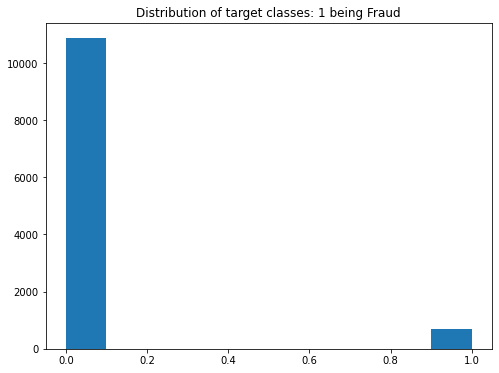

In [16]:
plt.figure(figsize = (8,6))
plt.hist(df['FraudFound_P'])
plt.title("Distribution of target classes: 1 being Fraud")
plt.show()

Pretty imbalanced.

In [50]:
noffound = len(df[df['FraudFound_P']==0])
ffound = len(df[df['FraudFound_P']==1])
print("Data points where there is no fraud found: ", noffound, "\n Data points where there is fraud found: ", ffound)

Data points where there is no fraud found:  10642 
 Data points where there is fraud found:  659


In [52]:
noffound-ffound

9983

**Age**

In [17]:
df.groupby('Age').size().reset_index(name='count').sort_values('Age')

,Age,count
0,0.0,253
1,16.0,8
2,17.0,5
3,18.0,34
4,19.0,24
...,...,...
61,76.0,32
62,77.0,20
63,78.0,26
64,79.0,12


Perhaps the Age at 0 is to account for individuals who did not give their age. Although it's 253 data points, its best to remove them for now.

In [18]:
df = df[df['Age'] > 0.0]

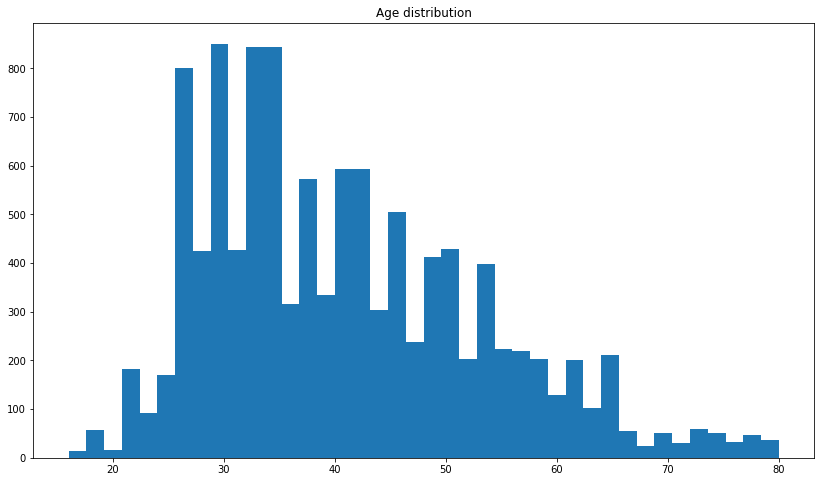

In [19]:
plt.figure(figsize = (14, 8))
plt.hist(x = df['Age'], bins = 40)
plt.title('Age distribution')
plt.show()

**Policy Number**

In [20]:
len(df['PolicyNumber'].unique())/len(df)

1.0

Seems like Policy Number is unique. Could it behave like an identifier?

**Year**

In [21]:
df['Year'].unique()

array([1994, 1995, 1996])

The data is only spread accross 3 years, 27-29 years ago... The aim is to improve a fraud detection model though, so it should be okay.

In [22]:
df.groupby('Year').size().reset_index(name='count').sort_values('Year')

,Year,count
0,1994,4468
1,1995,3844
2,1996,2989


The years are not too imabalanced, but could be improved.

**Claimsize**

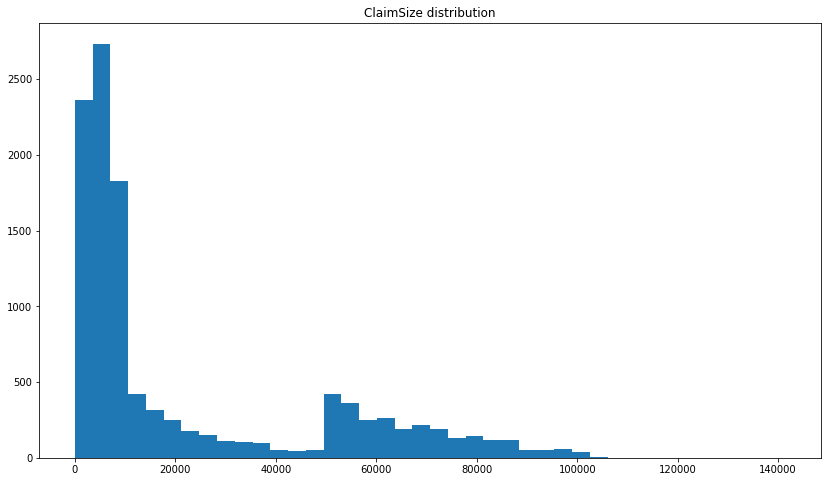

In [23]:
plt.figure(figsize = (14, 8))
plt.hist(x = df['ClaimSize'], bins = 40)
plt.title('ClaimSize distribution')
plt.show()

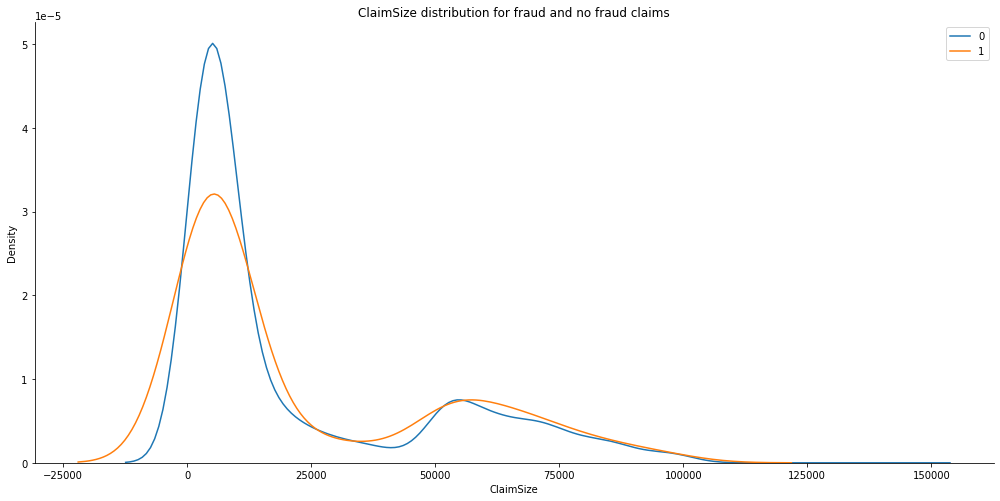

In [24]:
g = sns.FacetGrid(df, hue='FraudFound_P', height = 7, aspect = 2)
g.map(sns.kdeplot, 'ClaimSize')
plt.title('ClaimSize distribution for fraud and no fraud claims')
plt.legend()
plt.show()

**Car Model**

In [25]:
fraud_rate_make = df.groupby('Make').agg({
    "FraudFound_P": "mean", 
    "PolicyNumber": 'count'
})
fraud_rate_make.columns = ['FraudRate', '#']
fraud_rate_make = fraud_rate_make.apply(lambda x: round(x, 3))
fraud_rate_make.sort_values(by='FraudRate',ascending=False)

,FraudRate,#
Make,,
Mecedes,0.333,3
Accura,0.127,354
Saturn,0.098,41
Saab,0.087,69
Ford,0.074,338
Toyota,0.061,2315
Chevrolet,0.060,1252
Mercury,0.059,68
Honda,0.057,1909


The type of car make also seems to be pretty inbalanced.

**Policy Type**

In [26]:
fraud_rate_pt = df.groupby('PolicyType').agg({
    "FraudFound_P": "mean", 
    "PolicyNumber": 'count'
})
fraud_rate_pt.columns = ['FraudRate', '#']
fraud_rate_pt = fraud_rate_pt.apply(lambda x: round(x, 3))
fraud_rate_pt.sort_values(by='FraudRate',ascending=False)

,FraudRate,#
PolicyType,,
Sport - Collision,0.130,261
Utility - All Perils,0.127,245
Utility - Collision,0.125,24
Sedan - All Perils,0.097,2987
Sedan - Collision,0.067,4129
Sedan - Liability,0.007,3629
Sport - All Perils,0.000,12
Sport - Liability,0.000,1
Utility - Liability,0.000,13


#### Ordinal encoding

**Months**

In [27]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
          }
months_proc = lambda x: months.get(x, 0)

df['Month'] = df['Month'].apply(months_proc)
df['MonthClaimed'] = df['MonthClaimed'].apply(months_proc)

**Day of the week**

In [28]:
D_o_w = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
          }
D_o_w_proc = lambda x: D_o_w.get(x, 0)

df['DayOfWeek'] = df['DayOfWeek'].apply(D_o_w_proc)
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].apply(D_o_w_proc)

**Vehicle price**

Ordinal Encoding because classes have relative importance.

In [29]:
vehicle_prices = {
    'less than 20000': 1,
    '20000 to 29000' : 2,
    '30000 to 39000' : 3,
    '40000 to 59000' : 4,
    '60000 to 69000' : 5,
    'more than 69000': 6,
          }
vehicle_price_proc = lambda x: vehicle_prices.get(x, 0)

df['VehiclePrice'] = df['VehiclePrice'].apply(vehicle_price_proc)

**Age of Vehicle**

Also ordinal encoding

In [30]:
AgeOfVehicle_variants = {
    'new'         : 0.5,
    '2 years'     : 2,
    '3 years'     : 3,
    '4 years'     : 4,
    '5 years'     : 5,
    '6 years'     : 6,
    '7 years'     : 7,
    'more than 7' : 8.5,
          }
vehicle_age_proc = lambda x: AgeOfVehicle_variants[x]

df['AgeOfVehicle'] = df['AgeOfVehicle'].apply(vehicle_age_proc)

**Age of Policy Holder**

Also ordinal encoding.

In [31]:
age_variants = {
    '16 to 17'     : 1,
    '18 to 20'     : 2,
    '21 to 25'     : 3,
    '26 to 30'     : 4,
    '31 to 35'     : 5,
    '36 to 40'     : 6,
    '41 to 50'     : 7,
    '51 to 65'     : 8,
    'over 65'      : 9,
          }
age_proc = lambda x: age_variants[x]

df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].apply(age_proc)

#### One hot encoding

Creating a function to get the dummy variables for object type variables.

In [32]:
#this function creates the dummies for 1 column
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)

In [33]:
df = dummies(df)

In [34]:
df.head()

,dum: WitnessPresent: Yes,dum: VehicleCategory: Utility,dum: VehicleCategory: Sport,dum: Sex: Male,dum: PolicyType: Utility - Liability,dum: PolicyType: Utility - Collision,dum: PolicyType: Utility - All Perils,dum: PolicyType: Sport - Liability,dum: PolicyType: Sport - Collision,dum: PolicyType: Sport - All Perils,dum: PolicyType: Sedan - Liability,dum: PolicyType: Sedan - Collision,dum: PoliceReportFiled: Yes,dum: PastNumberOfClaims: none,dum: PastNumberOfClaims: more than 4,dum: PastNumberOfClaims: 2 to 4,dum: NumberOfSuppliments: none,dum: NumberOfSuppliments: more than 5,dum: NumberOfSuppliments: 3 to 5,dum: NumberOfCars: more than 8,dum: NumberOfCars: 5 to 8,dum: NumberOfCars: 3 to 4,dum: NumberOfCars: 2 vehicles,dum: MaritalStatus: Widow,dum: MaritalStatus: Single,dum: MaritalStatus: Married,dum: Make: VW,dum: Make: Toyota,dum: Make: Saturn,dum: Make: Saab,dum: Make: Porche,dum: Make: Pontiac,dum: Make: Nisson,dum: Make: Mercury,dum: Make: Mecedes,dum: Make: Mazda,dum: Make: Lexus,dum: Make: Jaguar,dum: Make: Honda,dum: Make: Ford,dum: Make: Ferrari,dum: Make: Dodge,dum: Make: Chevrolet,dum: Make: BMW,dum: Fault: Third Party,dum: Days_Policy_Claim: more than 30,dum: Days_Policy_Claim: 8 to 15,dum: Days_Policy_Accident: none,dum: Days_Policy_Accident: more than 30,dum: Days_Policy_Accident: 8 to 15,dum: Days_Policy_Accident: 15 to 30,dum: BasePolicy: Liability,dum: BasePolicy: Collision,dum: AgentType: Internal,dum: AddressChange_Claim: under 6 months,dum: AddressChange_Claim: no change,dum: AddressChange_Claim: 4 to 8 years,dum: AddressChange_Claim: 2 to 3 years,dum: AccidentArea: Urban,Year,WeekOfMonthClaimed,WeekOfMonth,VehiclePrice,RepNumber,PolicyNumber,MonthClaimed,Month,FraudFound_P,DriverRating,Deductible,DayOfWeekClaimed,DayOfWeek,ClaimSize,AgeOfVehicle,AgeOfPolicyHolder,Age
0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1994,1,5,6,12,1,1,12,0,1.0,300,2,3,55526.069421,3.0,4,21.0
1,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,4,3,6,15,2,1,1,0,4.0,400,1,3,59294.455571,6.0,5,34.0
2,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,2,5,6,7,3,11,10,0,3.0,400,4,5,71756.941320,7.0,7,47.0
3,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1994,1,2,2,4,4,7,6,0,2.0,400,5,6,7584.153493,8.5,8,65.0
4,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,3,1,6,14,7,2,2,0,1.0,400,1,6,98545.374339,7.0,6,36.0


In [35]:
len(df.columns)

76

#### Feature selection

We can see that later

#### Splitting the data

In [62]:
data, validation = train_test_split(df, test_size = 0.3, random_state = 42)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("FraudFound_P", axis = 1), 
                                                    data["FraudFound_P"], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

### Models

#### Logistic Regression

In [38]:
def eval_result(model, X_test, y_test, validation = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        pred = model.predict(X_test)

        print("\n", classification_report(y_test, pred, target_names = ['Not Fraud', 'Fraud']), "\n")

        display(pd.DataFrame(confusion_matrix(y_test, pred), 
                         columns = ['Predicted Not Fraud', 'Predicted Fraud'],
                         index = ['Not Fraud', 'Fraud']))
        
        print("\n")
        if hasattr(model, 'feature_importances_') and not validation:
            features = pd.DataFrame({
                'Variable'  :X_test.columns,
                'Importance':model.feature_importances_
            })
            features.sort_values('Importance', ascending=False, inplace=True)
            display(features.head(20))

In [39]:
lgmodel = LogisticRegression(
    solver='lbfgs', 
    class_weight={0:1.0, 1:9.5},
    n_jobs = -1,
    random_state = 101
)
lgmodel.fit(X_train, y_train)
eval_result(lgmodel, X_test, y_test)


               precision    recall  f1-score   support

   Not Fraud       0.95      0.91      0.93      2252
       Fraud       0.05      0.09      0.07       121

    accuracy                           0.87      2373
   macro avg       0.50      0.50      0.50      2373
weighted avg       0.90      0.87      0.89      2373
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2057,195
Fraud,110,11


#### Decision Tree Classifier

In [40]:
dtc = DecisionTreeClassifier(random_state = 101)
dtc.fit(X_train, y_train)
eval_result(dtc, X_test, y_test)


               precision    recall  f1-score   support

   Not Fraud       0.96      0.94      0.95      2252
       Fraud       0.18      0.23      0.20       121

    accuracy                           0.91      2373
   macro avg       0.57      0.59      0.57      2373
weighted avg       0.92      0.91      0.91      2373
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2121,131
Fraud,93,28


,Variable,Importance
64,PolicyNumber,0.196384
71,ClaimSize,0.112278
74,Age,0.065398
63,RepNumber,0.065303
66,Month,0.043144
70,DayOfWeek,0.042620
60,WeekOfMonthClaimed,0.042375
65,MonthClaimed,0.041413
44,dum: Fault: Third Party,0.034376
69,DayOfWeekClaimed,0.034261


#### XGBoost Classifier

In [41]:
xgbr = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr.fit(X_train, y_train)
eval_result(xgbr, X_test, y_test)


               precision    recall  f1-score   support

   Not Fraud       0.98      0.96      0.97      2252
       Fraud       0.45      0.57      0.50       121

    accuracy                           0.94      2373
   macro avg       0.71      0.77      0.74      2373
weighted avg       0.95      0.94      0.95      2373
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2168,84
Fraud,52,69


,Variable,Importance
51,dum: BasePolicy: Liability,0.286395
57,dum: AddressChange_Claim: 2 to 3 years,0.120161
44,dum: Fault: Third Party,0.116442
29,dum: Make: Saab,0.029724
54,dum: AddressChange_Claim: under 6 months,0.026033
12,dum: PoliceReportFiled: Yes,0.025290
5,dum: PolicyType: Utility - Collision,0.020354
56,dum: AddressChange_Claim: 4 to 8 years,0.019566
64,PolicyNumber,0.018908
65,MonthClaimed,0.016459


### Validation of the model

In [42]:
X_val = validation.drop('FraudFound_P', axis = 1)
y_val = validation['FraudFound_P']

In [43]:
eval_result(xgbr, X_val, y_val, validation = True)


               precision    recall  f1-score   support

   Not Fraud       0.97      0.98      0.97      3183
       Fraud       0.58      0.50      0.54       208

    accuracy                           0.95      3391
   macro avg       0.77      0.74      0.75      3391
weighted avg       0.94      0.95      0.95      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3108,75
Fraud,104,104


### Using GANs to make the dataset balanced

Only the target variable first

In [64]:
fraud_df = data[data['FraudFound_P']==1]

In [65]:
fraud_df = fraud_df.drop('FraudFound_P', axis = 1)

In [66]:
len(fraud_df)

451

In [71]:
len(data)

7910

In [72]:
7910-451

7459

Install and import ctgan 

In [47]:
!pip install ctgan 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0


In [67]:
from ctgan import CTGAN

#create list of discrete columns
discrete = ['dum: WitnessPresent: Yes',
 'dum: VehicleCategory: Utility',
 'dum: VehicleCategory: Sport',
 'dum: Sex: Male',
 'dum: PolicyType: Utility - Liability',
 'dum: PolicyType: Utility - Collision',
 'dum: PolicyType: Utility - All Perils',
 'dum: PolicyType: Sport - Liability',
 'dum: PolicyType: Sport - Collision',
 'dum: PolicyType: Sport - All Perils',
 'dum: PolicyType: Sedan - Liability',
 'dum: PolicyType: Sedan - Collision',
 'dum: PoliceReportFiled: Yes',
 'dum: PastNumberOfClaims: none',
 'dum: PastNumberOfClaims: more than 4',
 'dum: PastNumberOfClaims: 2 to 4',
 'dum: NumberOfSuppliments: none',
 'dum: NumberOfSuppliments: more than 5',
 'dum: NumberOfSuppliments: 3 to 5',
 'dum: NumberOfCars: more than 8',
 'dum: NumberOfCars: 5 to 8',
 'dum: NumberOfCars: 3 to 4',
 'dum: NumberOfCars: 2 vehicles',
 'dum: MaritalStatus: Widow',
 'dum: MaritalStatus: Single',
 'dum: MaritalStatus: Married',
 'dum: Make: VW',
 'dum: Make: Toyota',
 'dum: Make: Saturn',
 'dum: Make: Saab',
 'dum: Make: Porche',
 'dum: Make: Pontiac',
 'dum: Make: Nisson',
 'dum: Make: Mercury',
 'dum: Make: Mecedes',
 'dum: Make: Mazda',
 'dum: Make: Lexus',
 'dum: Make: Jaguar',
 'dum: Make: Honda',
 'dum: Make: Ford',
 'dum: Make: Ferrari',
 'dum: Make: Dodge',
 'dum: Make: Chevrolet',
 'dum: Make: BMW',
 'dum: Fault: Third Party',
 'dum: Days_Policy_Claim: more than 30',
 'dum: Days_Policy_Claim: 8 to 15',
 'dum: Days_Policy_Accident: none',
 'dum: Days_Policy_Accident: more than 30',
 'dum: Days_Policy_Accident: 8 to 15',
 'dum: Days_Policy_Accident: 15 to 30',
 'dum: BasePolicy: Liability',
 'dum: BasePolicy: Collision',
 'dum: AgentType: Internal',
 'dum: AddressChange_Claim: under 6 months',
 'dum: AddressChange_Claim: no change',
 'dum: AddressChange_Claim: 4 to 8 years',
 'dum: AddressChange_Claim: 2 to 3 years',
 'dum: AccidentArea: Urban',
 'Year',
 'WeekOfMonthClaimed',
 'WeekOfMonth',
 'VehiclePrice',
 'RepNumber',
 'PolicyNumber',
 'MonthClaimed',
 'Month',
 'DriverRating',
 'DayOfWeekClaimed',
 'DayOfWeek',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'Age']

In [68]:
ctgan = CTGAN(verbose=True)
ctgan.fit(data, discrete, epochs = 100)

Epoch 1, Loss G:  0.8421,Loss D: -1.7949
Epoch 2, Loss G: -0.7266,Loss D: -0.5984
Epoch 3, Loss G: -0.9274,Loss D: -0.1828
Epoch 4, Loss G: -1.2205,Loss D:  0.2833
Epoch 5, Loss G: -1.8053,Loss D:  0.0365
Epoch 6, Loss G: -2.4368,Loss D:  0.1939
Epoch 7, Loss G: -1.8087,Loss D:  0.1416
Epoch 8, Loss G: -1.6903,Loss D: -0.1849
Epoch 9, Loss G: -2.5497,Loss D: -0.3855
Epoch 10, Loss G: -2.9119,Loss D: -0.1452
Epoch 11, Loss G: -2.5742,Loss D: -0.0952
Epoch 12, Loss G: -2.0527,Loss D:  0.4452
Epoch 13, Loss G: -2.4655,Loss D: -0.3388
Epoch 14, Loss G: -2.5897,Loss D:  0.5266
Epoch 15, Loss G: -2.7095,Loss D: -0.4108
Epoch 16, Loss G: -2.4657,Loss D:  0.1396
Epoch 17, Loss G: -2.9893,Loss D: -0.0438
Epoch 18, Loss G: -3.0446,Loss D: -0.1017
Epoch 19, Loss G: -2.6319,Loss D:  0.4837
Epoch 20, Loss G: -1.9844,Loss D:  0.3737
Epoch 21, Loss G: -2.0323,Loss D: -0.5487
Epoch 22, Loss G: -2.5734,Loss D:  0.1305
Epoch 23, Loss G: -2.5360,Loss D: -0.1555
Epoch 24, Loss G: -2.3358,Loss D: -0.2029
E

In [73]:
samples = ctgan.sample(7459)

In [74]:
samples

,dum: WitnessPresent: Yes,dum: VehicleCategory: Utility,dum: VehicleCategory: Sport,dum: Sex: Male,dum: PolicyType: Utility - Liability,dum: PolicyType: Utility - Collision,dum: PolicyType: Utility - All Perils,dum: PolicyType: Sport - Liability,dum: PolicyType: Sport - Collision,dum: PolicyType: Sport - All Perils,dum: PolicyType: Sedan - Liability,dum: PolicyType: Sedan - Collision,dum: PoliceReportFiled: Yes,dum: PastNumberOfClaims: none,dum: PastNumberOfClaims: more than 4,dum: PastNumberOfClaims: 2 to 4,dum: NumberOfSuppliments: none,dum: NumberOfSuppliments: more than 5,dum: NumberOfSuppliments: 3 to 5,dum: NumberOfCars: more than 8,dum: NumberOfCars: 5 to 8,dum: NumberOfCars: 3 to 4,dum: NumberOfCars: 2 vehicles,dum: MaritalStatus: Widow,dum: MaritalStatus: Single,dum: MaritalStatus: Married,dum: Make: VW,dum: Make: Toyota,dum: Make: Saturn,dum: Make: Saab,dum: Make: Porche,dum: Make: Pontiac,dum: Make: Nisson,dum: Make: Mercury,dum: Make: Mecedes,dum: Make: Mazda,dum: Make: Lexus,dum: Make: Jaguar,dum: Make: Honda,dum: Make: Ford,dum: Make: Ferrari,dum: Make: Dodge,dum: Make: Chevrolet,dum: Make: BMW,dum: Fault: Third Party,dum: Days_Policy_Claim: more than 30,dum: Days_Policy_Claim: 8 to 15,dum: Days_Policy_Accident: none,dum: Days_Policy_Accident: more than 30,dum: Days_Policy_Accident: 8 to 15,dum: Days_Policy_Accident: 15 to 30,dum: BasePolicy: Liability,dum: BasePolicy: Collision,dum: AgentType: Internal,dum: AddressChange_Claim: under 6 months,dum: AddressChange_Claim: no change,dum: AddressChange_Claim: 4 to 8 years,dum: AddressChange_Claim: 2 to 3 years,dum: AccidentArea: Urban,Year,WeekOfMonthClaimed,WeekOfMonth,VehiclePrice,RepNumber,PolicyNumber,MonthClaimed,Month,FraudFound_P,DriverRating,Deductible,DayOfWeekClaimed,DayOfWeek,ClaimSize,AgeOfVehicle,AgeOfPolicyHolder,Age
0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1994,2,3,2,11,9388,12,12,0,4.0,400,1,2,4704.004402,5.0,8,36.0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1996,3,1,2,14,9069,7,11,0,4.0,400,1,5,3542.601015,7.0,7,34.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,2,4,6,4,8661,5,2,0,1.0,400,1,5,6656.432554,5.0,4,48.0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,1996,1,1,2,10,8603,10,6,0,1.0,400,5,4,2913.496539,7.0,7,40.0
4,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,1,1,2,3,9377,6,8,0,3.0,400,3,2,1987.655053,5.0,7,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1996,3,4,3,11,13453,1,4,0,3.0,400,5,2,46518.459172,7.0,6,42.0
7455,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1996,1,4,6,7,4152,3,10,1,3.0,400,1,4,24450.137415,6.0,7,57.0
7456,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,1996,3,2,2,4,3706,8,4,0,1.0,401,1,4,2827.349332,8.5,5,55.0
7457,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1996,5,1,2,16,4389,4,6,1,3.0,400,5,2,3195.126155,7.0,7,24.0


In [75]:
samples['FraudFound_P'] = 1
samples['FraudFound_P']

0       1
1       1
2       1
3       1
4       1
       ..
7454    1
7455    1
7456    1
7457    1
7458    1
Name: FraudFound_P, Length: 7459, dtype: int64

In [76]:
augmented = pd.concat([samples,data],ignore_index=True, axis = 0)
augmented = augmented.sample(frac=1).reset_index(drop=True)

In [77]:
augmented

,dum: WitnessPresent: Yes,dum: VehicleCategory: Utility,dum: VehicleCategory: Sport,dum: Sex: Male,dum: PolicyType: Utility - Liability,dum: PolicyType: Utility - Collision,dum: PolicyType: Utility - All Perils,dum: PolicyType: Sport - Liability,dum: PolicyType: Sport - Collision,dum: PolicyType: Sport - All Perils,dum: PolicyType: Sedan - Liability,dum: PolicyType: Sedan - Collision,dum: PoliceReportFiled: Yes,dum: PastNumberOfClaims: none,dum: PastNumberOfClaims: more than 4,dum: PastNumberOfClaims: 2 to 4,dum: NumberOfSuppliments: none,dum: NumberOfSuppliments: more than 5,dum: NumberOfSuppliments: 3 to 5,dum: NumberOfCars: more than 8,dum: NumberOfCars: 5 to 8,dum: NumberOfCars: 3 to 4,dum: NumberOfCars: 2 vehicles,dum: MaritalStatus: Widow,dum: MaritalStatus: Single,dum: MaritalStatus: Married,dum: Make: VW,dum: Make: Toyota,dum: Make: Saturn,dum: Make: Saab,dum: Make: Porche,dum: Make: Pontiac,dum: Make: Nisson,dum: Make: Mercury,dum: Make: Mecedes,dum: Make: Mazda,dum: Make: Lexus,dum: Make: Jaguar,dum: Make: Honda,dum: Make: Ford,dum: Make: Ferrari,dum: Make: Dodge,dum: Make: Chevrolet,dum: Make: BMW,dum: Fault: Third Party,dum: Days_Policy_Claim: more than 30,dum: Days_Policy_Claim: 8 to 15,dum: Days_Policy_Accident: none,dum: Days_Policy_Accident: more than 30,dum: Days_Policy_Accident: 8 to 15,dum: Days_Policy_Accident: 15 to 30,dum: BasePolicy: Liability,dum: BasePolicy: Collision,dum: AgentType: Internal,dum: AddressChange_Claim: under 6 months,dum: AddressChange_Claim: no change,dum: AddressChange_Claim: 4 to 8 years,dum: AddressChange_Claim: 2 to 3 years,dum: AccidentArea: Urban,Year,WeekOfMonthClaimed,WeekOfMonth,VehiclePrice,RepNumber,PolicyNumber,MonthClaimed,Month,FraudFound_P,DriverRating,Deductible,DayOfWeekClaimed,DayOfWeek,ClaimSize,AgeOfVehicle,AgeOfPolicyHolder,Age
0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1994,1,4,2,11,11043,8,12,1,4.0,400,3,2,5681.293174,6.0,5,41.0
1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1996,3,3,2,5,13711,2,2,0,2.0,400,2,2,17733.816733,8.5,7,52.0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,1,3,6,3,12631,10,3,1,3.0,400,3,2,1784.642019,7.0,5,38.0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1996,3,1,2,7,5147,6,1,1,3.0,400,1,2,617.513466,7.0,7,48.0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1994,3,3,4,5,4507,2,5,1,1.0,400,3,3,3275.568743,8.5,5,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15364,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1995,1,4,3,7,7193,6,5,0,1.0,700,5,3,67101.082830,7.0,7,53.0
15365,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1994,4,4,2,14,11017,5,4,1,1.0,493,2,5,4779.840383,7.0,4,53.0
15366,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1996,2,2,2,2,15270,5,5,0,1.0,400,2,1,7378.039533,7.0,6,36.0
15367,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1996,4,4,2,6,14358,10,10,0,2.0,400,4,3,3312.634606,6.0,5,34.0


#### Comparing performance of models

Does the performance increase? Is GANs method performing better than other methods, such as upsampling and downsampling?

In [78]:
X_train_a = augmented.drop('FraudFound_P', axis = 1)
y_train_a = augmented['FraudFound_P']

xgbr_2 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr_2.fit(X_train_a, y_train_a)
eval_result(xgbr_2, X_val, y_val, validation = True)


               precision    recall  f1-score   support

   Not Fraud       0.98      0.94      0.96      3183
       Fraud       0.42      0.68      0.52       208

    accuracy                           0.92      3391
   macro avg       0.70      0.81      0.74      3391
weighted avg       0.94      0.92      0.93      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2992,191
Fraud,67,141


Which metric should we look at in priority?

### SMOTE

In [79]:
from imblearn.over_sampling import SMOTE

In [81]:
X = data.drop("FraudFound_P", axis = 1)
y = data["FraudFound_P"]

# we create the smote object (upsampling)
sm = SMOTE(random_state=42)

#upsampling the minority class (ignition = 1)
X_upsampled, y_upsampled = sm.fit_resample(X, y)

xgbr_3 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr_3.fit(X_upsampled, y_upsampled)
eval_result(xgbr_3, X_val, y_val, validation = True)


               precision    recall  f1-score   support

   Not Fraud       0.97      0.96      0.96      3183
       Fraud       0.44      0.50      0.47       208

    accuracy                           0.93      3391
   macro avg       0.71      0.73      0.72      3391
weighted avg       0.93      0.93      0.93      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3054,129
Fraud,105,103


### Next Steps


- Similarity checks (clustering, PCA, similarity measures for distribution correlation etc...)
- Improving precision & recall by changing parameters in the synthetic data generation process
- Think about inclusing upsampling in the synthetic data generation library (with a parameters = TRUE if we want to upsample data)